# Skin cancer task


In [1]:
import torch
import medmnist
from medmnist import INFO
from bin.interpreting_medmnist.analyse_features import *
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from bin.load_model import *
import random


In [2]:
# Task info

info = INFO['dermamnist']
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
labels = info['label']

dataroot = "/Users/sva/Documents/GitHub/MedMnist"

task_info = f'''
Our task is to {task} {n_channels}x28x18 images.
We have {n_classes} classes with labels: {labels}
'''

print(task_info)



Our task is to multi-class 3x28x18 images.
We have 7 classes with labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}



In [3]:
DataClass = getattr(medmnist, info['python_class'])

# preprocessing
data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[.5], std=[.5])])

# load the data
train_dataset = DataClass(
        root=dataroot + "/Train", split='train', transform=data_transform, download=False)
test_dataset = DataClass(
        root=dataroot + "/Test", split='test', transform=data_transform, download=False)

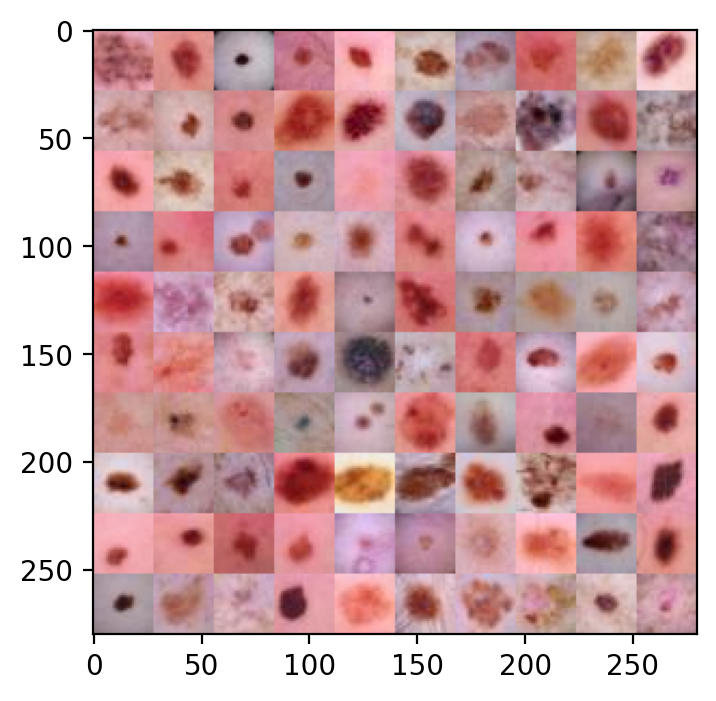

In [4]:
# plot 10 random images from the train dataset

fig = train_dataset.montage(length=10)
plt.rcParams['figure.dpi'] = 200
plt.imshow(fig)

<BarContainer object of 7 artists>

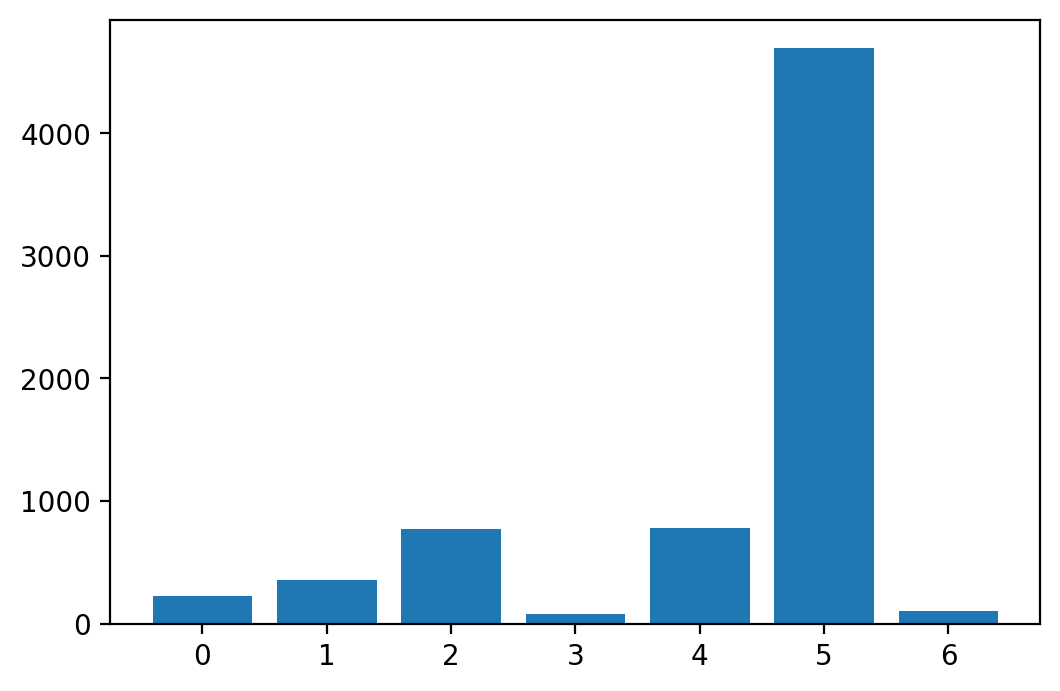

In [5]:
# Count class samples

classes = [0]*7
for i in range(len(train_dataset)):
    cl = train_dataset[i][1].tolist()[0]
    classes[cl] += 1

plt.bar(range(7),classes)

In [6]:
# Load trained flan model from config path

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
config_path = "/Users/sva/kme_net/bin/examples/config_medmnist.json"
model, train_loader, test_loader = load_kme_model(config_path, device)


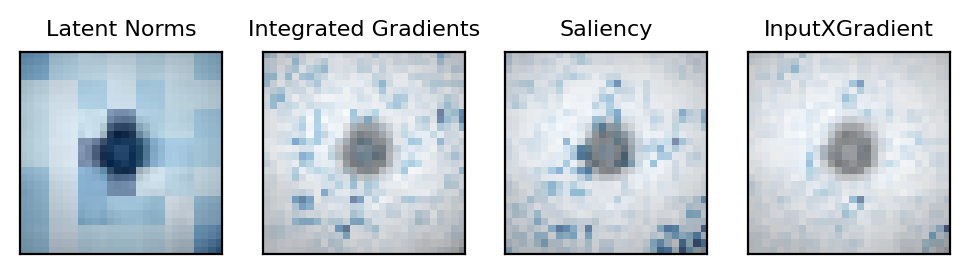

In [7]:
%%capture --no-display
# FLAN's importance scores compared to other post-hoc methods

id = 0 # image id
attribute_image_comparison_skincancer(model, train_loader, id, device, dataroot)
plt.rcParams['figure.dpi'] = 500

In [8]:
# Algorithmic Interpretation #The probabilities for the top 3 classes 
# for the full model and for the 5 pixels with the highest importance scores #This might take a while
df = algor_inter(model, train_loader, id=0) 
df.replace(np.nan, '-', regex=True)


,0,1,2,3,4,5,6
full model,-,-,0.021,0.223,-,0.737,-
Pixel 1,-,0.248,0.174,-,0.308,-,-
Pixel 2,-,-,0.156,-,0.175,0.545,-
Pixel 3,-,0.155,-,0.194,0.467,-,-
Pixel 4,0.128,0.429,-,-,-,0.158,-
Pixel 5,0.134,-,0.124,-,0.456,-,-


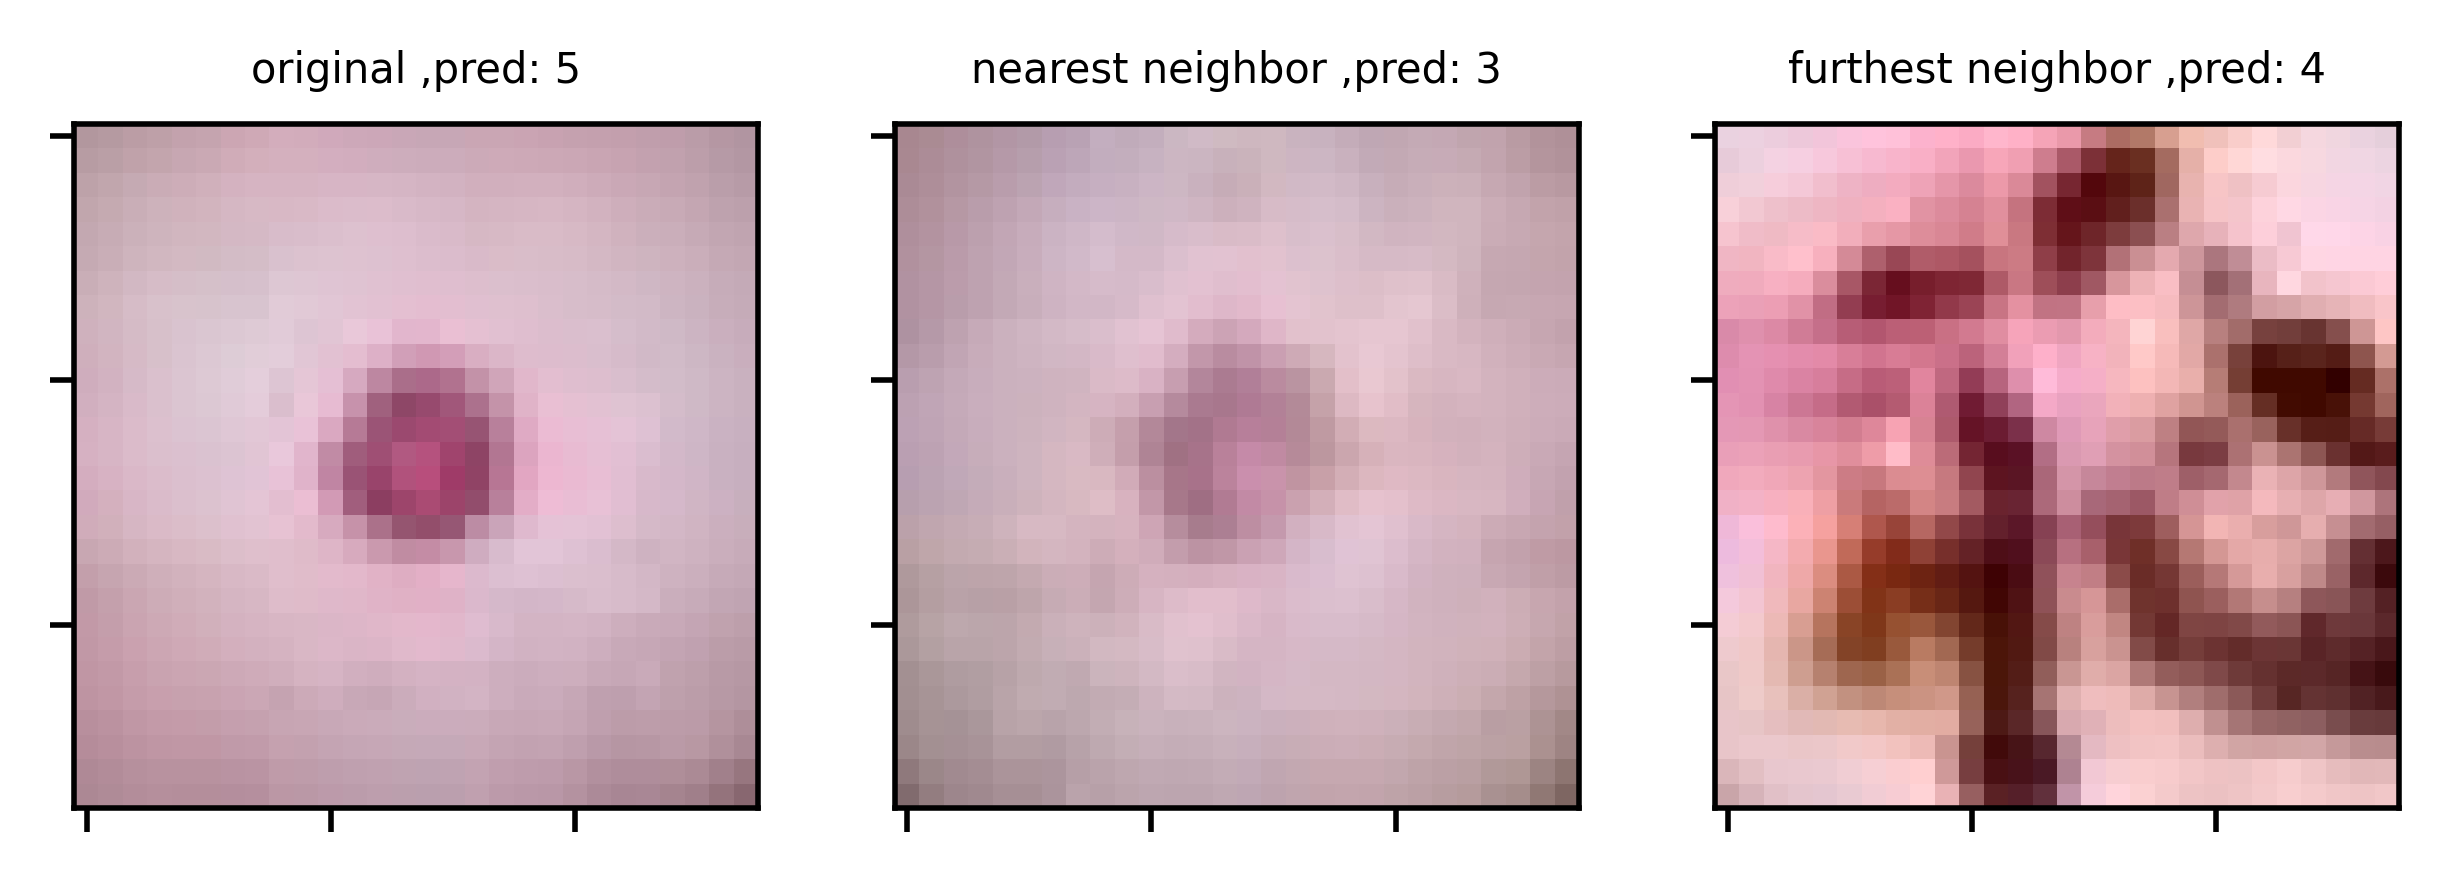

In [9]:
# Example based
# For a sample i, we find the closest and the furthest away neighbor in the latent space.
examples, predictions = find_neighbors(model, train_loader, id=0)
plot_neighbors(examples, predictions)


In [ ]:
# Exampled based 2
# We split the samples into 7 groups with respect to FLAN's predictions and
# use K-medoits to find the 3 centers of each group.
medoit_data = global_ex_based(model,train_loader,no_clusters=3)
plot_centers(medoit_data,  group_id = 6)